In [137]:
from reservoirUtils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Schaeffer et al. 
### Comparison to ideal bayesian baseline

(<Figure size 1200x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f87de9d9a20>)

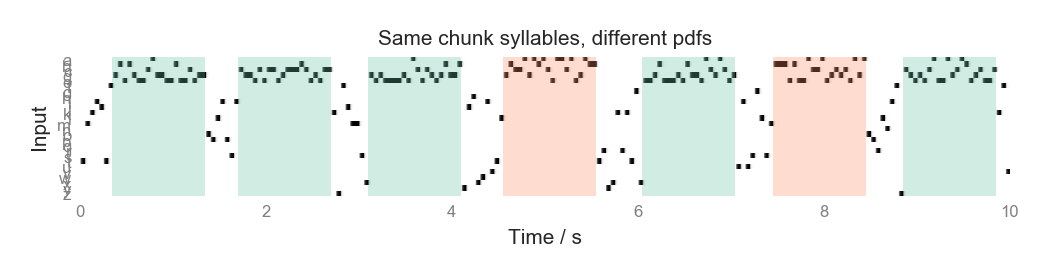

In [159]:
inputParams = defaultInputParams.copy()
inputParams['experiment'] = 'schaeffer'
inputParams['chunkList'] = [['a','b','c','d','e']]
inputParams['interChunkSyllables'] = alphabet[5:]
r = 1.5
inputParams['pdfs'] = [[r**0,r**1,r**2,r**3,r**4],[r**4,r**3,r**2,r**1,r**0]]
inputParams['chunkSize'] = 20
inputParams['gapRange'] = [5,10]
inputs = getInputs(inputParams,totalTime=400)
inputsTest = getInputs(inputParams,totalTime=200)

plotInputs(inputsTest,title='Same chunk syllables, different pdfs',tend=10)

In [157]:
hyperparams = {'Ng' : 300, #no. neurons in each reservoir 
               'n' : 150, #no. reservoir neurons the output neuron is connected to 
               'p' : 0.5, #connection probability amongst recurrent units
               'tau' : 10, #neuron time constant, in ms 
               'dt' : 1, #simulation timestep in ms
               'g_GG' : 1.5, #RNN chaos parameters ( > 1 means chaos)
               'g_Gz' : 1, #feedback strength,
               'alpha' : 100, #learning rate
               'sigma' : 0.1,#amount of network noise
               'Nz' : 2, #no. of output neurons
               'Ni' : inputs['data'].shape[1],
               'ipr' : 3} #each reservoir neuron connects to (on av) ipr input nodes

In [147]:
reservoirPair = ReservoirPair(hyperparams,inputs)
reservoirPair.storeInputs(inputsTest,name='test')
reservoirPair.trainPair()
reservoirPair.testPair(testName='test',testData='test',Ntest=10,returnItems=['z'])

Training reservoir pair:   0%|          | 0/400000 [00:00<?, ?it/s]

Running multiple tests of reservoir:   0%|          | 0/10 [00:00<?, ?it/s]

Test 0:   0%|          | 0/200000 [00:00<?, ?it/s]

Test 1:   0%|          | 0/200000 [00:00<?, ?it/s]

Test 2:   0%|          | 0/200000 [00:00<?, ?it/s]

Test 3:   0%|          | 0/200000 [00:00<?, ?it/s]

Test 4:   0%|          | 0/200000 [00:00<?, ?it/s]

Test 5:   0%|          | 0/200000 [00:00<?, ?it/s]

Test 6:   0%|          | 0/200000 [00:00<?, ?it/s]

Test 7:   0%|          | 0/200000 [00:00<?, ?it/s]

Test 8:   0%|          | 0/200000 [00:00<?, ?it/s]

Test 9:   0%|          | 0/200000 [00:00<?, ?it/s]

In [148]:
pickleAndSave(reservoirPair,'schaeffer_r2')

In [185]:
reservoirPair = loadAndDepickle('schaeffer_r2')

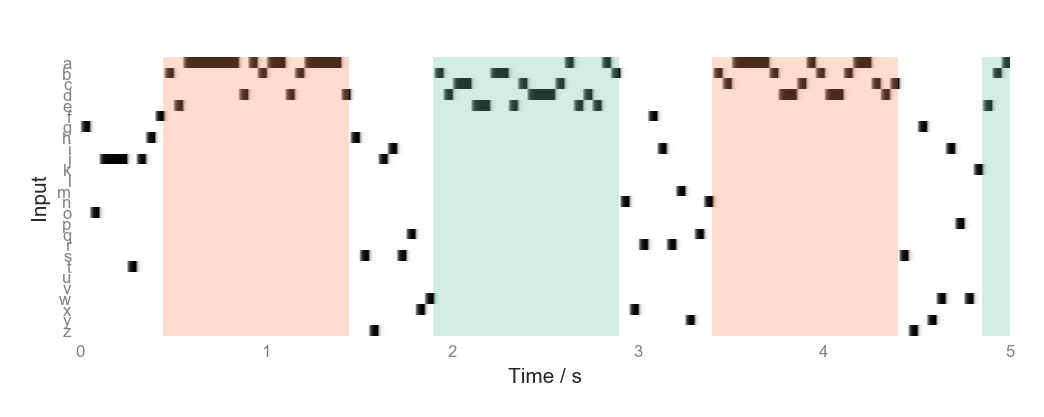

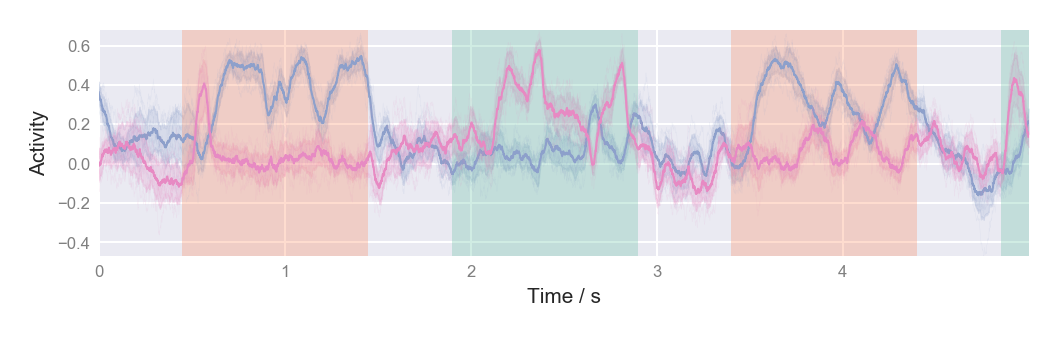

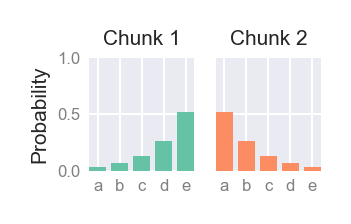

In [179]:
plotInputs(reservoirPair.inputDict['test'], tend=5,saveName="schaefferInput")
plotTest(reservoirPair,testName='test',testData='test',tend=5,colorOrders=[2,3],saveName="schaefferz")

fig, ax = plt.subplots(1,2,figsize=(1,0.5),sharey=True)
prob_c1 = reservoirPair.inputDict['test']['inputParams']['pdfs'][0] / np.sum(reservoirPair.inputDict['test']['inputParams']['pdfs'][0])
prob_c2 = reservoirPair.inputDict['test']['inputParams']['pdfs'][1] / np.sum(reservoirPair.inputDict['test']['inputParams']['pdfs'][1])
ax[0].bar(['a','b','c','d','e'],prob_c1,color='C0')
ax[1].bar(['a','b','c','d','e'],prob_c2,color='C1')
ax[0].set_title("Chunk 1")
ax[1].set_title("Chunk 2")
ax[0].set_ylabel("Probability")
ax[0].set_ylim([0,1])
plt.savefig("./figures/chunkprobsschaeffer20.png",dpi=300,bbox_inches='tight')

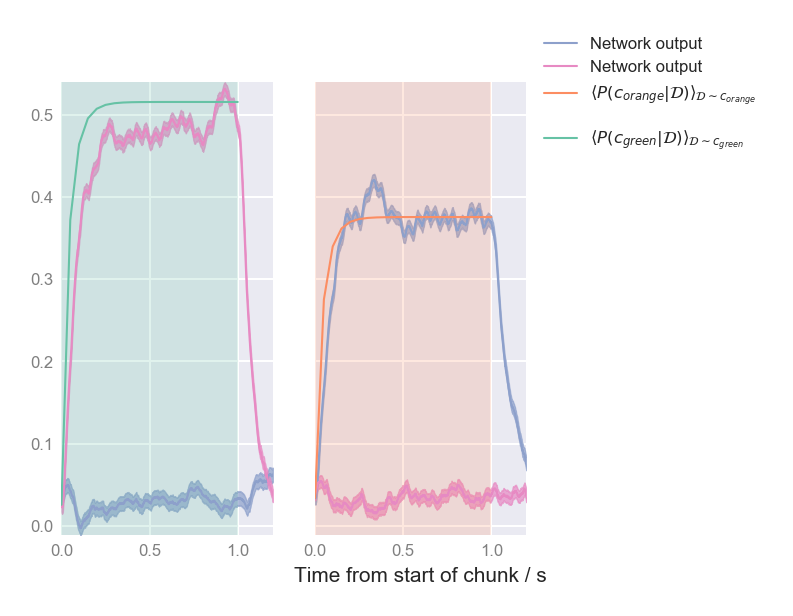

In [186]:
inputs = reservoirPair.inputDict['test']
inputParams = inputs['inputParams']
data = reservoirPair.hist['test']


#average over all the chunk data 
avResults = {}

for chunkId in [0,1]:
    avResults[chunkId] = {}
    for outputId in [0,1]:
        avResults[chunkId][outputId] = {}
        avResults[chunkId][outputId]['n'] = 0
        avResults[chunkId][outputId]['av'] = np.zeros(inputParams['chunkSize']*50+200)
        avResults[chunkId][outputId]['var'] = np.zeros(inputParams['chunkSize']*inputParams['width']+200)
    avResults[chunkId]['posterior_c1'] = np.zeros(inputParams['chunkSize']+1)
    avResults[chunkId]['posterior_c2'] = np.zeros(inputParams['chunkSize']+1)
    avResults[chunkId]['n'] = 0
    
for n_trial in range(data['z'].shape[2]):
    for chunk in inputs['chunkData'][1:-1]:
        chunkId = chunk[0]
        start = np.argmin(np.abs(inputs['t'] - chunk[1]))
        for outputId in [0,1]:
            avResults[chunkId][outputId]['n'] += 1
            x = data['z'][outputId,start:start+(inputParams['chunkSize']*50+200),n_trial]
            n = avResults[chunkId][outputId]['n']
            av = avResults[chunkId][outputId]['av']
            nvar = avResults[chunkId][outputId]['var']
            newAv = (1 - 1/n)*av + (1/n)*x
            avResults[chunkId][outputId]['av'] = newAv
            if n >= 2: 
                avResults[chunkId][outputId]['var'] = nvar + (x-av)*(x-newAv) #Welfords algorithm 

for chunkId in [0,1]:
    for outputId in [0,1]:
        avResults[chunkId][outputId]['std'] = (avResults[chunkId][outputId]['var']/(avResults[chunkId][outputId]['n']-1))**(1/2)

        
    
fig, ax = plt.subplots(1,2,figsize=(2,2),sharey=True)

#plot average results 
for chunkId in [0,1]:
    for outputId in [0,1]:
        av = avResults[chunkId][outputId]['av']
        n = avResults[chunkId][outputId]['n']
        ci95 = 1.96*avResults[chunkId][outputId]['std'][0]/np.sqrt(n)
        t = inputs['t'][:inputParams['chunkSize']*inputParams['width']+200]
        if chunkId == 1: ax[chunkId].plot(t,av,c='C'+str(outputId+2),zorder=1,label='Network output')
        else: ax[chunkId].plot(t,av,c='C'+str(outputId+2),zorder=1)
        ax[chunkId].fill_between(t,av+ci95,av-ci95,color='C'+str(outputId+2),alpha=0.7,zorder=1)

#add shade rectangles to highlight chunk
rect = matplotlib.patches.Rectangle((0,ax[0].get_ylim()[0]),inputParams['chunkSize']*inputParams['width']/1000,(ax[0].get_ylim()[1]-ax[0].get_ylim()[0]),linewidth=0,facecolor='C0',alpha=0.2)
rect1 = matplotlib.patches.Rectangle((0,ax[0].get_ylim()[0]),inputParams['chunkSize']*inputParams['width']/1000,(ax[0].get_ylim()[1]-ax[0].get_ylim()[0]),linewidth=0,facecolor='C1',alpha=0.2)
ax[0].add_patch(rect)
ax[1].add_patch(rect1)




likelihood_c1 = inputParams['pdfs'][0]/np.sum(inputParams['pdfs'][0])
likelihood_c2 = inputParams['pdfs'][1]/np.sum(inputParams['pdfs'][1])

risingOutput = np.argmax([max(avResults[0][0]['av']),max(avResults[0][1]['av'])])
avPostc1 = getAveragePosterior(likelihood_c1, likelihood_c2,nObservations = inputParams['chunkSize'])
avPostc1 = (np.mean(avResults[0][risingOutput]['av'][(inputParams['chunkSize']-3)*inputParams['width']:(inputParams['chunkSize'])*inputParams['width']]) - np.min(avResults[0][risingOutput]['av'])) / (np.mean(avPostc1[-3:]) - min(avPostc1))*avPostc1
avPostc1 += avResults[0][risingOutput]['av'][0] - avPostc1[0]
ax[0].plot(np.arange(inputParams['chunkSize']+1)*0.05,avPostc1,c='C0',label=r"$\langle P(c_{green}|\mathcal{D})\rangle_{\mathcal{D} \sim c_{green}}$")

risingOutput = np.argmax([max(avResults[1][0]['av']),max(avResults[1][1]['av'])])
avPostc1 = getAveragePosterior(likelihood_c1, likelihood_c2, nObservations = inputParams['chunkSize'])
avPostc1 = (np.mean(avResults[1][risingOutput]['av'][(inputParams['chunkSize']-3)*inputParams['width']:(inputParams['chunkSize'])*inputParams['width']]) - np.min(avResults[1][risingOutput]['av'])) / (np.mean(avPostc1[-3:]) - min(avPostc1))*avPostc1
avPostc1 += avResults[1][risingOutput]['av'][0] - avPostc1[0]
ax[1].plot(np.arange(inputParams['chunkSize']+1)*0.05,avPostc1,c='C1',label=r"$\langle P(c_{orange} | \mathcal{D})\rangle_{\mathcal{D} \sim c_{orange}}$")

ax[0].legend(loc=[2.25,0.83])
ax[1].legend(loc=[1.05,0.93])

plt.xlabel('Time from start of chunk / s')

plt.savefig("./figures/schaefferbayes20.png",dpi=300,bbox_inches='tight')